#  This is Lab 2 executable file
This file contains the program code that is the solution to the tasks from the file [lab_2_task.txt](https://github.com/vandosik/M-M-MSA/blob/master/Lab_2/lab_2_task.txt).
## Authors
* Ivan Dubinin: [vandosik](https://github.com/vandosik)
* Alexey Grandilevskii: [zer0deck](https://github.com/zer0deck)
* Mikhail Sorokin: [Mikha1lSorokin](https://github.com/Mikha1lSorokin)

In [1]:
# libs initialization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from scipy.optimize import curve_fit 
import seaborn as sns

In [2]:
# Dataset initialization
path_to_file = '../Datasets/GameStats.csv'
source_df = pd.read_csv(path_to_file, engine='python')
source_df.head(5)

,Date,Level,NumBlocks,IsWin,ElapsedTime,Score,Accuracy
0,9/7/2019 2:43:29 PM,520,30,False,1.579998,150,0.0
1,9/7/2019 2:44:46 PM,520,30,False,3.805001,100,0.0
2,9/7/2019 2:59:20 PM,520,30,False,1.783006,50,0.0
3,9/7/2019 2:59:28 PM,520,30,True,0.263020,0,0.0
4,9/7/2019 2:59:48 PM,520,30,True,3.318019,50,0.0


Date:        date and time the game was auto-played

Level:       the 3-digit number is an estimate of the difficulty from a previous run

NumBlocks:   how many blocks have to be broken to win the level

IsWin:       True if autoplay broke all the blocks, False if the ball fell past the paddle

ElapsedTime: Seconds until either won or lost (game is played at 4x speed, so multiply by 4 to get an estimate of how long a human might play it)

Score:       total score when the game was won or lost

Accuracy:    the autoplay is tuned with a randomly-chosen accuracy. Higher numbers are more likely to win;

In [3]:
# Select column

# col_names = ['Date',	'Level',	'NumBlocks',	'IsWin',	'ElapsedTime',	'Score',	'Accuracy']
col_names = list(source_df.columns)
# col_name = col_names[4]
# col_name = "Accuracy"
# col_name = "ElapsedTime"
col_name = "Score"

In [4]:
# Remove outliers
if True: # cut by quantiles
    if col_name == 'ElapsedTime':
        up_quant = 0.995
        down_quant = 0.005
    elif col_name == 'Accuracy':
        up_quant = 0.995
        down_quant = 0.005
    elif col_name == 'Score':
        up_quant = 0.9835
        down_quant = 0.0001

    q_low = source_df[col_name].quantile(down_quant)
    q_hi  = source_df[col_name].quantile(up_quant)

    source_df = source_df[(source_df[col_name] < q_hi) & (source_df[col_name] > q_low)]
else: # cut by zscore
    source_df[(np.abs(scipy.stats.zscore(source_df)) < 3).all(axis=1)]

>The code above is identical for all labs and is used to initialize the dataset.

## Exercise №1
You need to make a non-parametric estimation of PDF in form of histogram and using kernel density function for MRV (or probability law in case of discrete MRV).

No handles with labels found to put in legend.


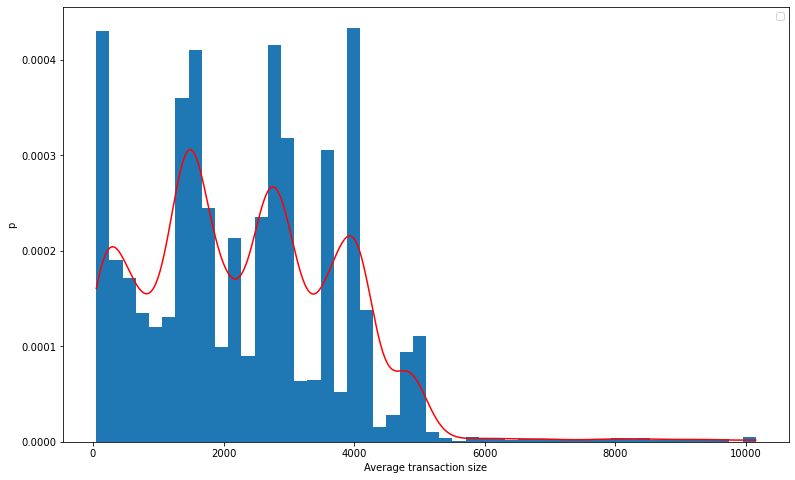

In [5]:
#Plotting a histogram and kernel density estimate
plt.figure(figsize=(13, 8))

kernel = scipy.stats.gaussian_kde(source_df[col_name])

min_amount, max_amount = source_df[col_name].min(), source_df[col_name].max()
x = np.linspace(min_amount, max_amount, len(source_df)) # by defaul 50 items
kde_values = kernel(x)

# sns.histplot(source_df[col_name], kde=False, stat="density", label=f'Average transaction size in rubles')
# Draw unnormed histogramm
hist_data = plt.hist(source_df[col_name], density=True, bins=50)

# print(hist_vals)
plt.plot(x, kde_values, color="r")

plt.ylabel('p')
plt.xlabel('Average transaction size')

plt.legend()
plt.show()

## Exercise №2
You need to make an estimation of multivariate mathematical expectation and variance.

In [6]:
# Calculating multivariate mathematical expectation and variance
var = source_df[col_name].var()

## Exercise №3
You need to make a non-parametric estimation of conditional distributions, mathematical expectations and variances. 

## Exercise №4
You need to make an estimation of pair correlation coefficients, confidence intervals for them and significance levels.

## Exercise №5
Choose a task formulation for regression. Estimate multivariate correlation (target - predictors).

## Exercise №6
Build regression model and make an analysis of multicollinearity and regularization (if needed). 

## Exercise №7
Analyze the quality of regression model (distribution of residuals, determination coefficient).